**Training code has been put on [github](https://github.com/mikelkl/APTOS2019)**

**For detailed summary, please refer to [this blog](https://zhuanlan.zhihu.com/p/81695773)**

# General
This is a not bad solution to get top2% without TTA or coefficient optimization.

# Our Solution
## Data Augumentation
-  Introduce [2015 Diabetic Retinopathy competition data](https://www.kaggle.com/tanlikesmath/diabetic-retinopathy-resized)
- Conduct regular transformations that create less black padding
  - do_flip
  - flip_vert
  - max_zoom
  
## Preprocessing
- Thanks to the [@Neuron Engineer](https://www.kaggle.com/ratthachat), we refer to his [APTOS [UpdatedV14] Preprocessing- Ben's & Cropping](https://www.kaggle.com/ratthachat/aptos-updatedv14-preprocessing-ben-s-cropping), and set `sigmaX=10`

## Pretrained Model
- We choose [EfficientNet-PyTorch](https://github.com/lukemelas/EfficientNet-PyTorch) as our base model, this series model are quite accurate and fast to train.

## Training
- Because this is a ordinal classification task, we train it as regression problem.
- We first pretrain model on 2015 data, then finetune on 2019 data

## Ensemble
### Stage 1
- Train `efficientnet-b3, efficientnet-b4, efficientnet-b5` models on splitted 5-fold data resulting in 15 base models.

### Stage 2
- Train [xgboost](https://github.com/dmlc/xgboost), [svr](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html), [catboost](https://github.com/catboost/catboost) models on logits output of stage 1 base model.

### Stage 3
- Bagging from stage 2 models

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd

import os
import cv2
import torch
import numpy as np

import sys
package_dir = '../input/efficientnet/efficientnet-pytorch/EfficientNet-PyTorch/'
sys.path.insert(0, package_dir)

import efficientnet_pytorch 

from tqdm import tqdm_notebook
from sklearn.metrics import cohen_kappa_score
from fastai.vision import *
from torch.nn import functional as F
import time
import pickle as pk

#time clock counting
start = time.time()

In [2]:
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
SEED = 999
seed_everything(SEED)

In [3]:
deployment_dir = "../input/efficientnetstacking"

def qk(y_pred, y):
    k = torch.tensor(cohen_kappa_score(torch.round(y_pred), y, weights='quadratic'), device='cuda:0')
    k[k != k] = 0
    k[torch.isinf(k)] = 0
    
    return k

test_df = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')

# Preprocess Image and save on disk

In [4]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
    
IMG_SIZE = 512

def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

In [5]:
from tqdm import tqdm_notebook
from PIL import Image
import multiprocessing as mp
save_dir = "../input/test_images_ben_preprocessing_sigmaX10"
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
NCORE = 20

In [6]:
sv_t1 = time.time()
def process(q, iolock):
    while True:
        stuff = q.get()
        if stuff is None:
            break
        idx, row = stuff
        path=f"../input/aptos2019-blindness-detection/test_images/{row['id_code']}.png"
        image = load_ben_color(path,sigmaX=10)
        Image.fromarray(image).save(os.path.join(save_dir, "{}.png".format(row['id_code'])))

q = mp.Queue(maxsize=NCORE)
iolock = mp.Lock()
pool = mp.Pool(NCORE, initializer=process, initargs=(q, iolock))
for idx, row in tqdm_notebook(test_df.iterrows()):
    stuff = (idx, row)
    q.put(stuff)  # blocks until q below its max size
for _ in range(NCORE):  # tell workers we're done
    q.put(None)
pool.close()
pool.join()  
sv_t2 = time.time()
sv_dur = sv_t2 - sv_t1
print('Preprocessing and save takes time ... {} seconds , {} hours'.format(sv_dur,sv_dur/3600))
##Preprocessing and save takes time ... 349.69464921951294 seconds , 0.09713740256097582 hours


Preprocessing and save takes time ... 357.6067280769348 seconds , 0.099335202243593 hours


In [7]:
!du -sh ../input/test_images_ben_preprocessing_sigmaX10

579M	../input/test_images_ben_preprocessing_sigmaX10


# Stage1&2 Inference

(1928, 1)
[03:31:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


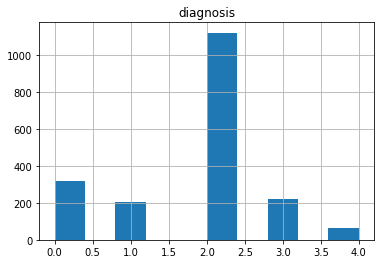

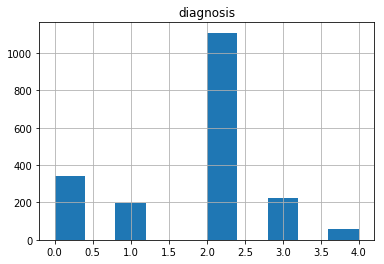

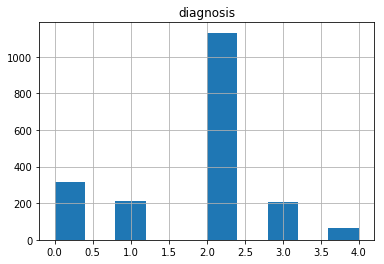

Inference duration  349.231999874115 0.09700888885392082


In [8]:
inf1_t1 = time.time()

b3_models = ["efficientnet-b3_0901_16-45-51_stage2_f1", "efficientnet-b3_0901_16-45-51_stage2_f2",
                  "efficientnet-b3_0901_16-45-51_stage2_f3", "efficientnet-b3_0901_16-45-51_stage2_f4",
                  "efficientnet-b3_0901_16-45-51_stage2_f5"]

b3_test_logits_list = []
for m in b3_models:
    learn = load_learner(deployment_dir, "{}.pkl".format(m))

    learn.data.add_test(ImageList.from_df(test_df,
                                      '../input',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))

    logits,_ = learn.get_preds(DatasetType.Test)
    logits = logits.numpy()
    b3_test_logits_list.append(logits)
    
    print(logits.shape)
    
b4_models = ["efficientnet-b4_0820_01-09-57_stage2_f1", "efficientnet-b4_0820_01-09-57_stage2_f2",
                  "efficientnet-b4_0820_01-09-57_stage2_f3", "efficientnet-b4_0820_01-09-57_stage2_f4",
                  "efficientnet-b4_0821_00-02-25_stage2_f5"]

b4_test_logits_list = []
for m in b4_models:
    learn = load_learner(deployment_dir, "{}.pkl".format(m))

    learn.data.add_test(ImageList.from_df(test_df,
                                      '../input',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))

    logits,_ = learn.get_preds(DatasetType.Test)
    logits = logits.numpy()
    b4_test_logits_list.append(logits)
    
    print(logits.shape)
    
b5_models = ["efficientnet-b5_0820_01-32-30_stage2_f1", "efficientnet-b5_0903_01-03-41_stage2_f2",
                  "efficientnet-b5_0820_22-13-07_stage2_f3", "efficientnet-b5_0821_01-30-37_stage2_f4",
                  "efficientnet-b5_0821_00-26-51_stage2_f5"]

b5_test_logits_list = []
for m in b5_models:
    learn = load_learner(deployment_dir, "{}.pkl".format(m))

    learn.data.add_test(ImageList.from_df(test_df,
                                      '../input',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))
    logits,_ = learn.get_preds(DatasetType.Test)
    logits = logits.numpy()
    b5_test_logits_list.append(logits)
    
    print(logits.shape)
    
with open(os.path.join(deployment_dir, "xgboost-0903_05-26-03.pkl"), "rb") as f:
    xlf = pk.load(f)
    
with open(os.path.join(deployment_dir, "svr-0903_05-26-03.pkl"), "rb") as f:
    svr = pk.load(f)

with open(os.path.join(deployment_dir, "cb-0906_06-09-42.pkl"), "rb") as f:
    cb = pk.load(f)
    
# 5 test feature then avg
results_xlf = []
results_svr = []
results_cb = []
for b3, b4, b5 in zip(b3_test_logits_list, b4_test_logits_list, b5_test_logits_list):
    X_test = np.concatenate([b3, b4, b5], axis=1)
    res_xlf = xlf.predict(X_test)
    results_xlf.append(res_xlf)
    
    res_svr = svr.predict(X_test)
    results_svr.append(res_svr)
    
    res_cb = cb.predict(X_test)
    results_cb.append(res_cb)

avg_res_xlf = np.average(results_xlf, axis=0)
avg_res_svr = np.average(results_svr, axis=0)
avg_res_cb = np.average(results_cb, axis=0)

y_pred_xlf = np.round(avg_res_xlf).astype(int)
y_pred_svr = np.round(avg_res_svr).astype(int)
y_pred_cb = np.round(avg_res_cb).astype(int)

test_df.diagnosis = y_pred_xlf
test_df.hist()
plt.show()

test_df.diagnosis = y_pred_svr
test_df.hist()
plt.show()

test_df.diagnosis = y_pred_cb
test_df.hist()
plt.show()

inf1_t2 = time.time()
inf1_dur = inf1_t2 - inf1_t1
print('Inference duration ',inf1_dur, inf1_dur/3600)

# Stage3 Bagging

## Correlation Analysis

In [9]:
np.corrcoef([avg_res_xlf, avg_res_svr, avg_res_cb])

array([[1.      , 0.997143, 0.997563],
       [0.997143, 1.      , 0.998309],
       [0.997563, 0.998309, 1.      ]])

In [10]:
np.corrcoef([y_pred_xlf, y_pred_svr, y_pred_cb])

array([[1.      , 0.975527, 0.978376],
       [0.975527, 1.      , 0.983601],
       [0.978376, 0.983601, 1.      ]])

In [11]:
def voting(labels, Tweights = None):
    if isinstance(labels, list):
        X = np.array(labels, dtype=np.int64)   
        maj = np.argmax(np.bincount(X, Tweights))
    return maj

def average(logits, Tweights = None):
    avg = np.average(logits, axis=0, weights = Tweights)
    return avg

In [12]:
vote_list = [voting([int(avg_res_xlf[idx] + 0.5), 
                    int(avg_res_svr[idx] + 0.5), 
                    int(avg_res_cb[idx] + 0.5)]) 
            for idx in range(len(avg_res_xlf))]

# Submission

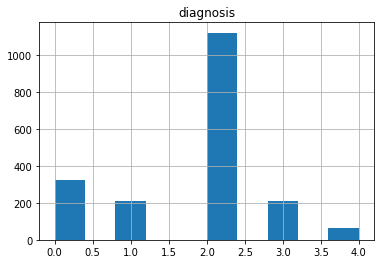

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [13]:
test_df.diagnosis = vote_list
test_df.hist()
plt.show()

test_df.to_csv('submission.csv',index=False)

In [14]:
test_df['diagnosis'].value_counts()

2    1122
0     323
3     210
1     209
4      64
Name: diagnosis, dtype: int64

In [15]:
dur = time.time() -start
print('Whole procedure takes {} seconds long ...'.format(dur))
print(dur/3600)
print ('done')

Whole procedure takes 710.5857803821564 seconds long ...
0.19738493899504345
done
